# S3: QQ Plots

In [11]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn022


In [12]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [13]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)


def qq_plot(df_results, filename, figsize=(10, 16), tcga=True, title_fontsize=12):
    
    cols = 4
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Plot observed vs. theoretical p-values
        ax.scatter(expected, pvals, alpha=0.6)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[len(cohort.split("_"))-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nN genes = {df["n_genes"].unique()[0]}\nN mut = {df["n_mut"].unique()[0]}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n  -log10(p-values)")
    
    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

In [14]:
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


,Gene,Uniprot_ID,Cohort,pval,qval,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,n_genes,n_mut
0,BRAF,P15056,TCGA_WXS_MEL,0.00001,0.0,154.374330,245.0,269,10058,165420
1,NRAS,P01111,TCGA_WXS_MEL,0.00001,0.0,57.088760,126.0,127,10058,165420
2,MAP2K1,A4QPA9,TCGA_WXS_MEL,0.00001,0.0,8.864405,20.0,27,10058,165420
3,CNOT9,D5MQE1,TCGA_WXS_MEL,0.00001,0.0,7.687517,14.0,15,10058,165420
4,RAC1,A4D2P1,TCGA_WXS_MEL,0.00001,0.0,7.117122,18.0,22,10058,165420
...,...,...,...,...,...,...,...,...,...,...
36091,UBE3C,Q15386,TCGA_WXS_CHRCC,0.04960,1.0,1.719813,2.0,2,7,28
36092,ATP6V0A4,A0A024R791,TCGA_WXS_CHRCC,0.05770,1.0,1.685607,2.0,2,7,28
36093,CREG2,Q8IUH2,TCGA_WXS_CHRCC,0.08770,1.0,1.592002,2.0,2,7,28
36094,GAL3ST3,Q96A11,TCGA_WXS_CHRCC,0.11200,1.0,1.508403,2.0,2,7,28


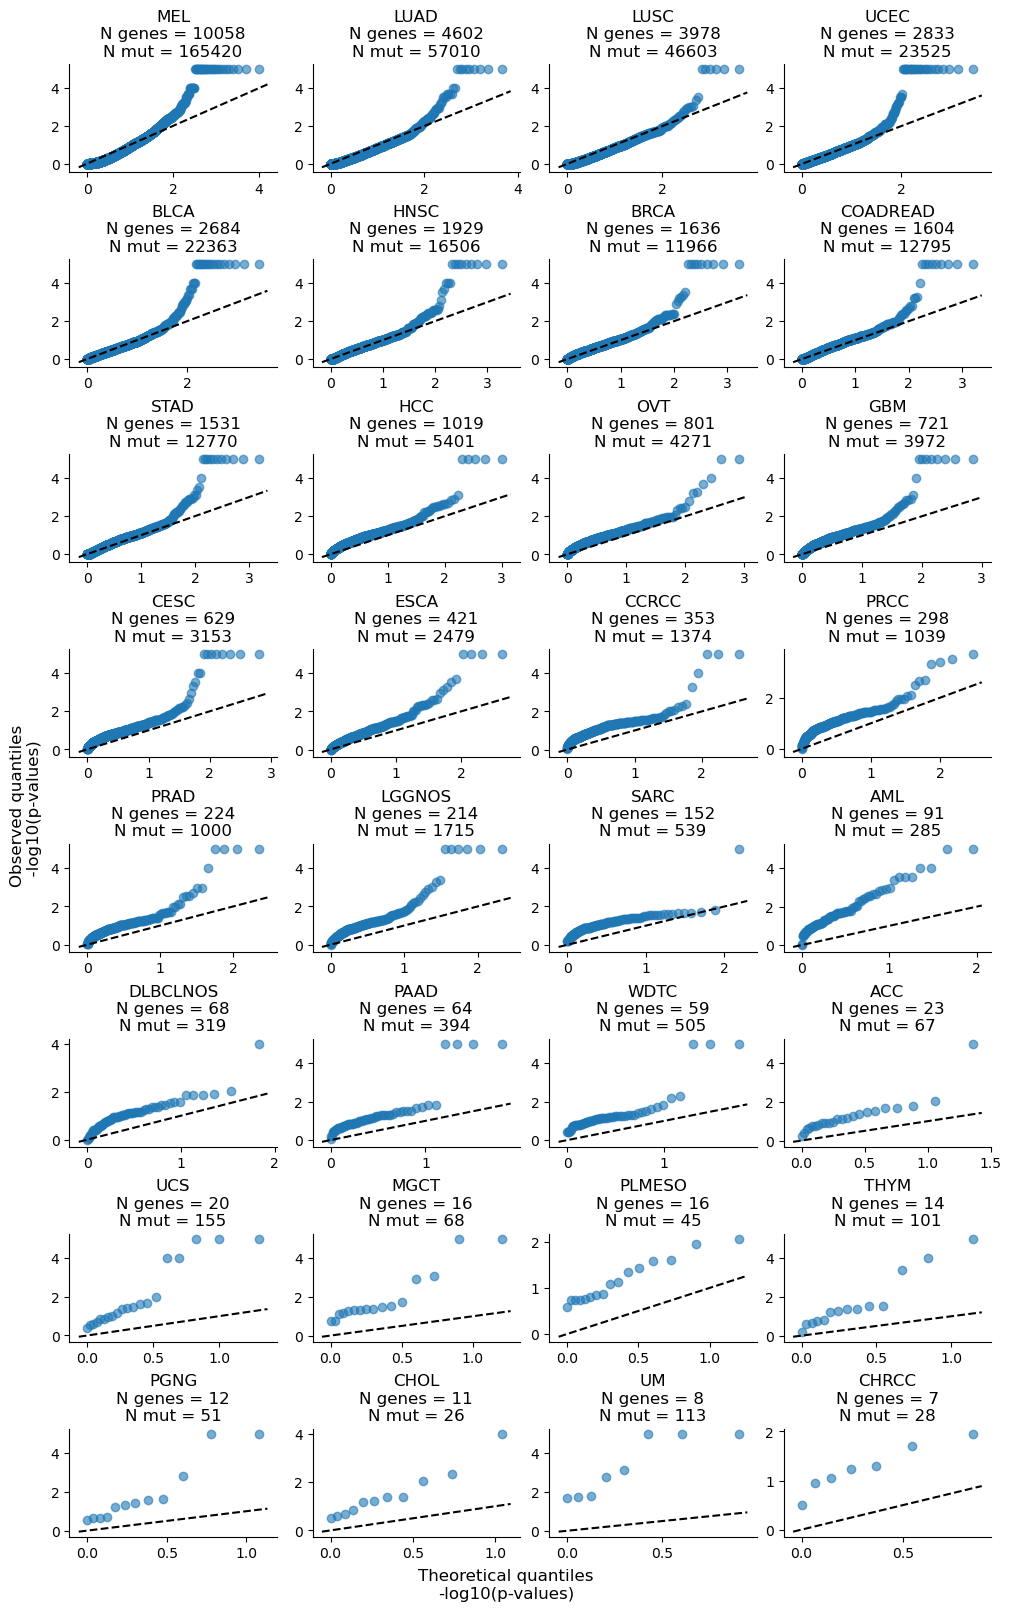

In [15]:
qq_plot(df_results, filename=False)

## Filter by sample size (processed genes)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


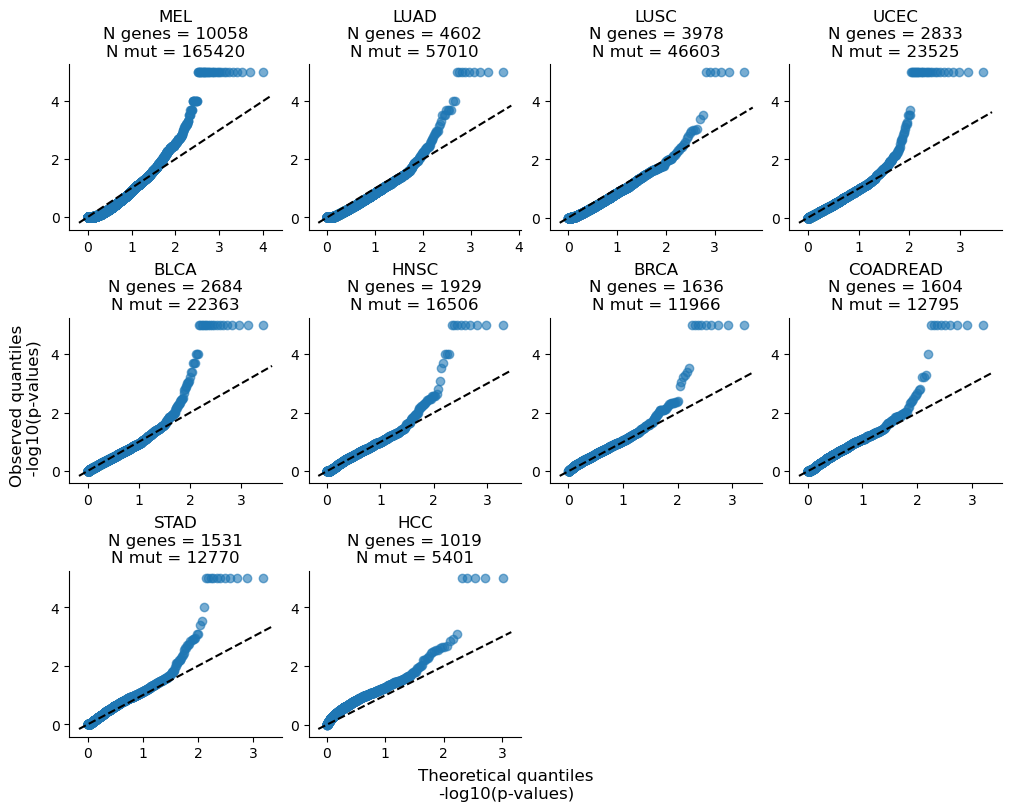

In [16]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1000)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
qq_plot(df_results, filename=False, figsize=(10, 8))

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


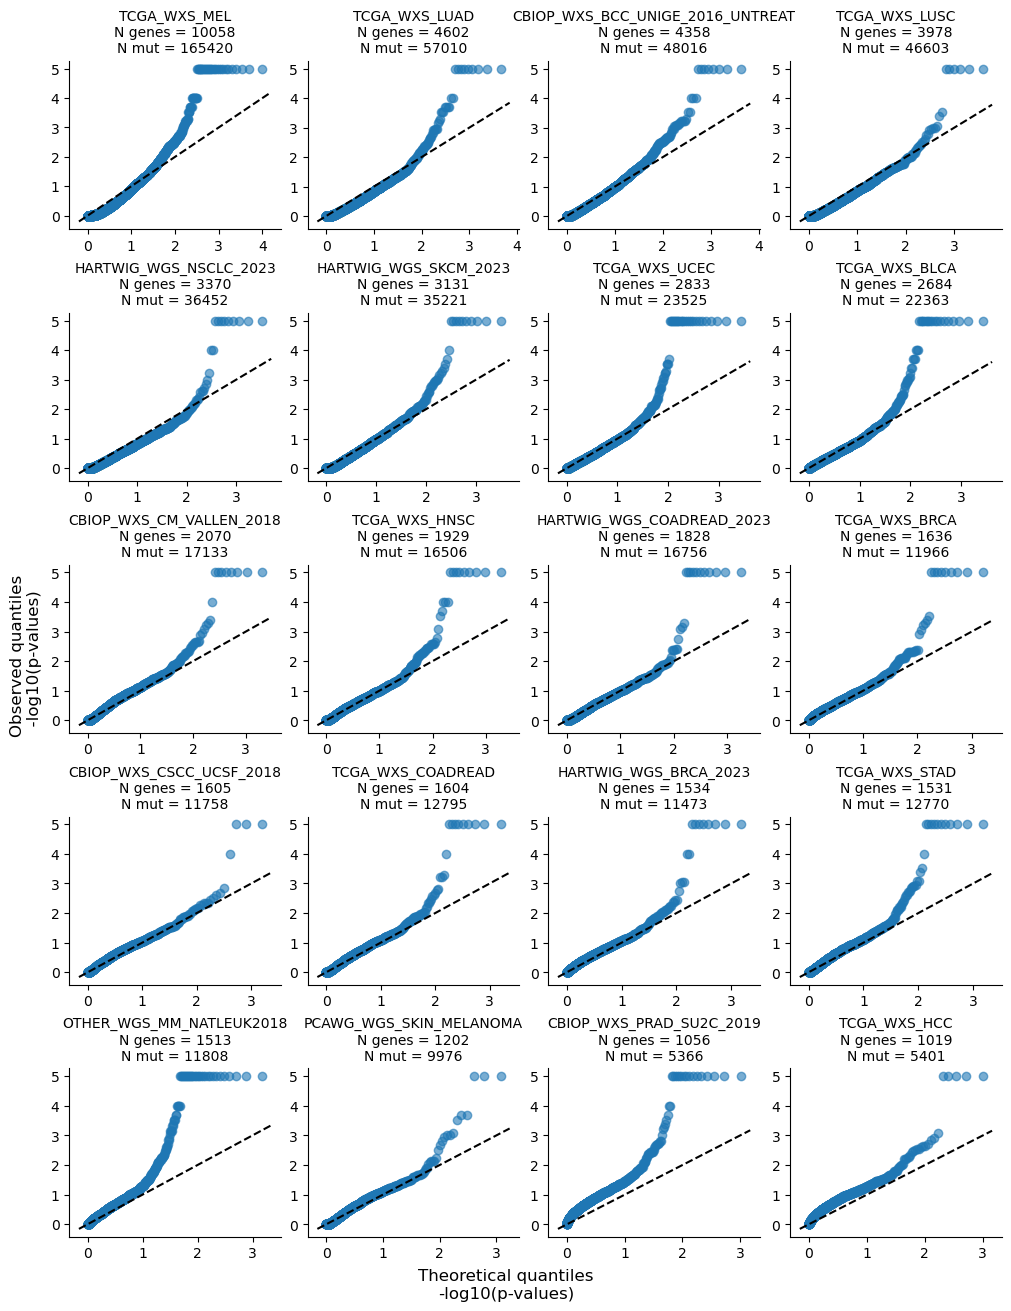

In [17]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1000)
qq_plot(df_results, filename=False, figsize=(10, 13), tcga=False, title_fontsize=10)

## We compute the score at the level of gene-cohort: so a sample size that might affect the score is the number of number of mutations in the gene


Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


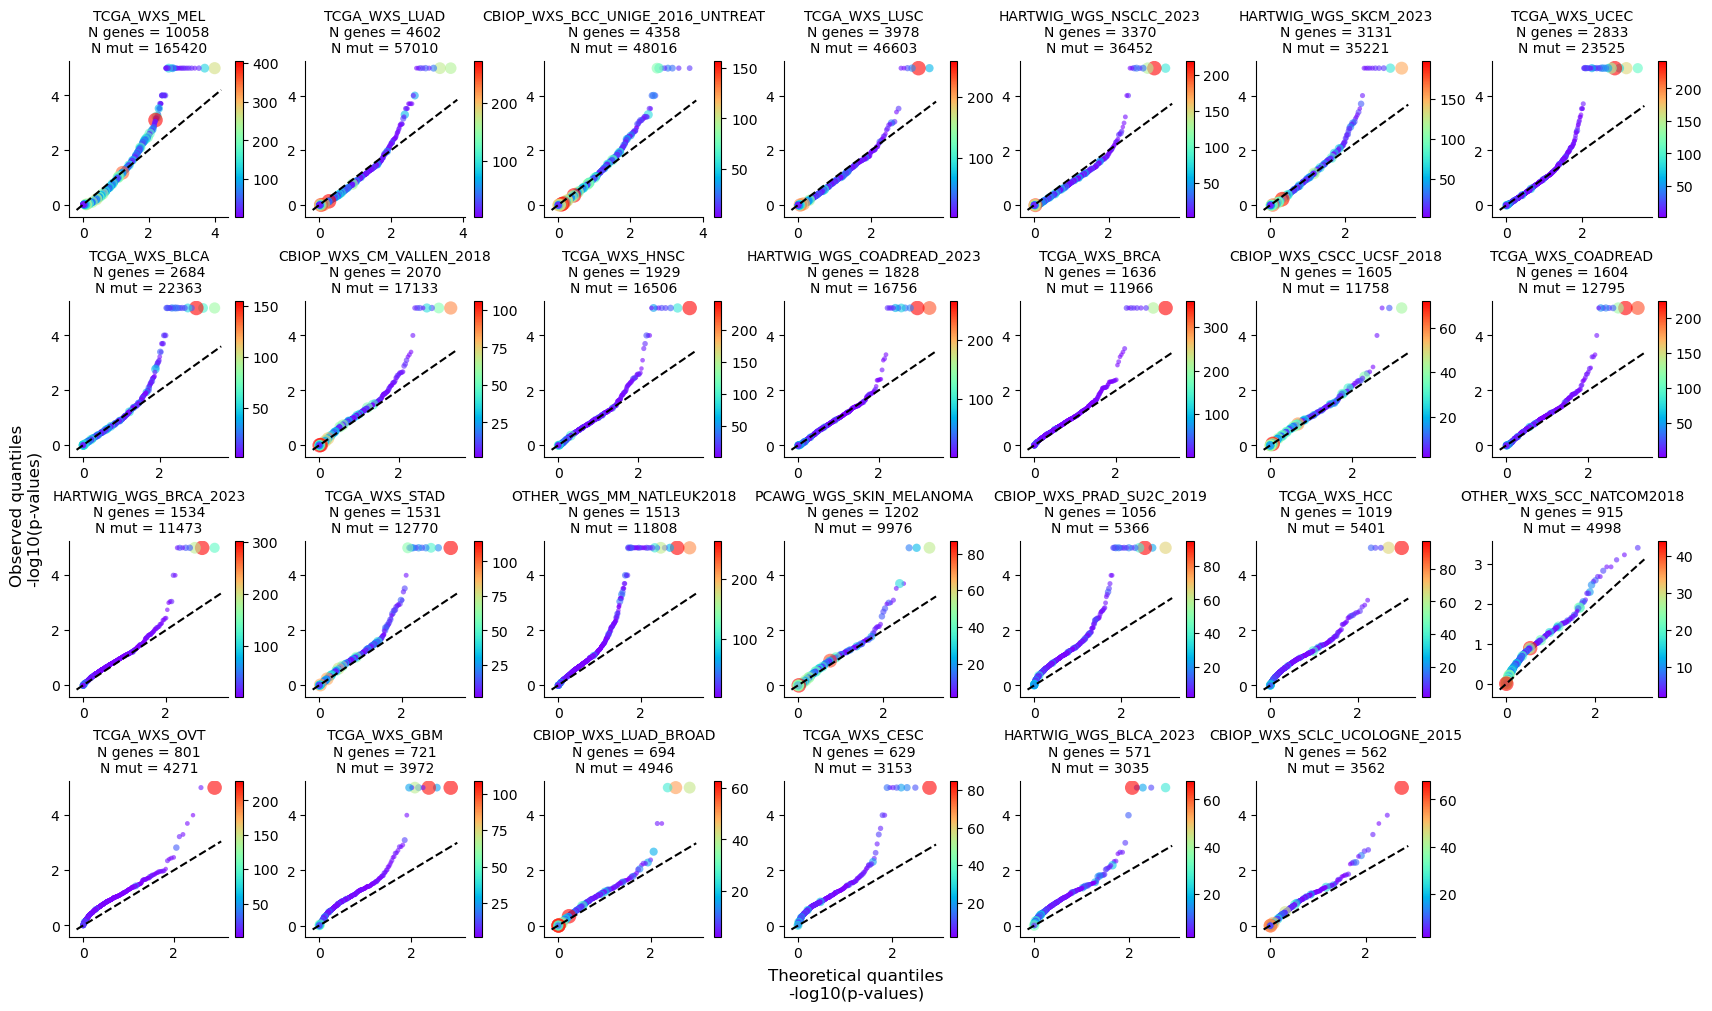

In [20]:
def qq_plot(df_results, filename=None, figsize=(10, 16), tcga=True, title_fontsize=12, cols=4):
    
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    cmap = plt.cm.rainbow  # Using the rainbow colormap

    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Normalize colors and sizes based on Mut_in_gene
        norm = plt.Normalize(df["Mut_in_gene"].min(), df["Mut_in_gene"].max())
        size_scale = (df["Mut_in_gene"] - df["Mut_in_gene"].min()) / (df["Mut_in_gene"].max() - df["Mut_in_gene"].min())
        marker_sizes = 10 + (size_scale * 100)  # Scale marker sizes between 10 and 100

        # Scatter plot with size and color based on "Mut_in_gene"
        scatter = ax.scatter(expected, pvals, c=df["Mut_in_gene"], cmap=cmap, norm=norm, s=marker_sizes, alpha=0.6, lw=0)
        
        # Expected line (y=x)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nN genes = {df["n_genes"].unique()[0]}\nN mut = {df["n_mut"].unique()[0]}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add color bar next to each subplot
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', 
                            fraction=1, pad=0.04)
        # cbar.set_label("Mutations in Gene")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Common x and y labels
    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n-log10(p-values)")

    # Save the figure if filename is provided
    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=500)
qq_plot(df_results, filename=False, figsize=(17, 10), tcga=False, title_fontsize=10, cols=7)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


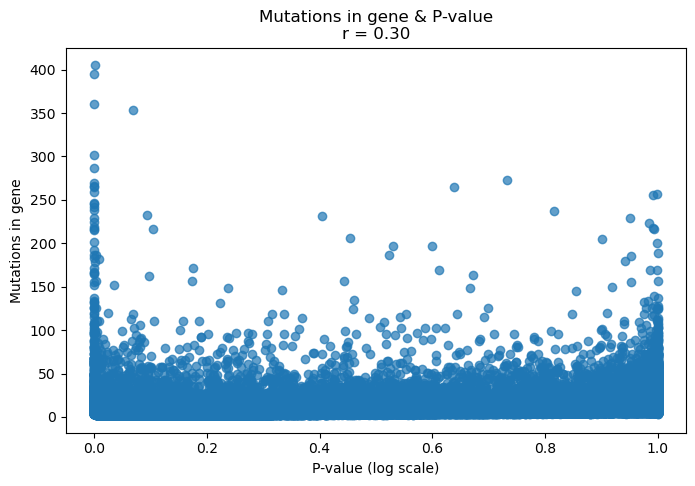

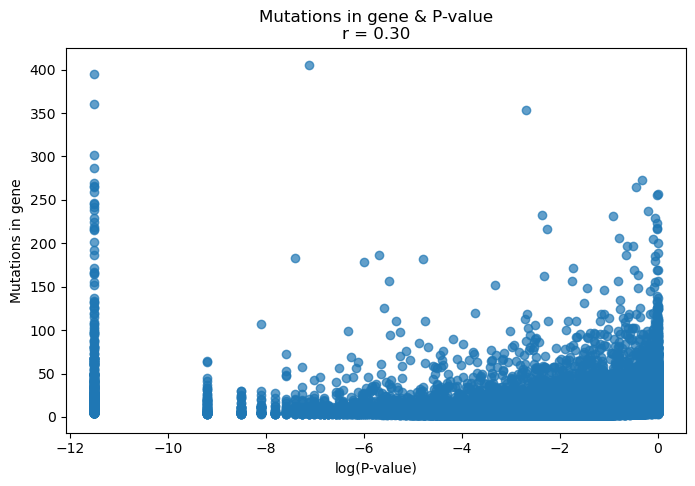

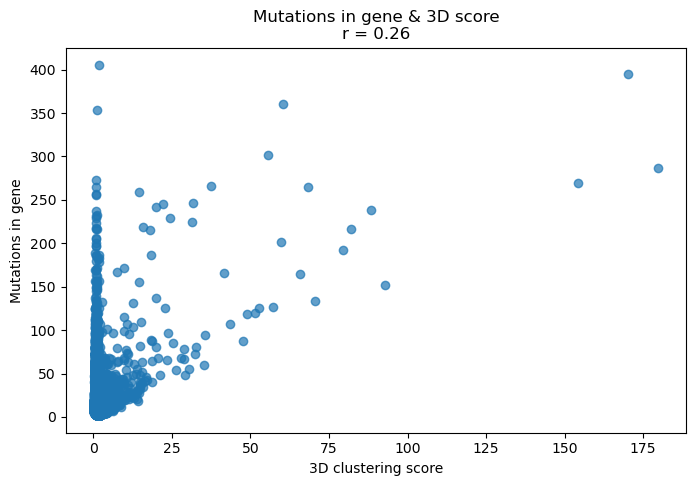

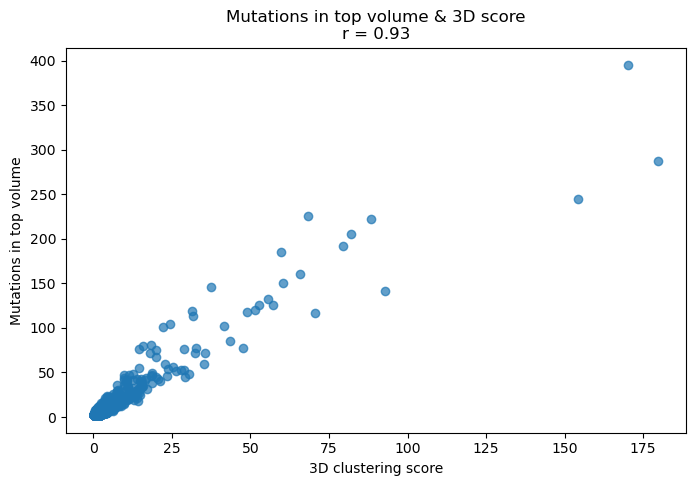

In [9]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["pval"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("P-value (log scale)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(np.log(df["pval"]), df["Mut_in_gene"], alpha=0.7)
plt.xlabel("log(P-value)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_top_vol"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in top volume")
plt.title(f'Mutations in top volume & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_top_vol"]):.2f}')
plt.show()



# Not-normalized 3D clustering score

## Notes
* We only compute p-values for genes with at least 2 mutations in the volume of any residue
* The pvalues of cohorts with 1000+ processed genes (N) seem to be well calibrated 
* There isn't an apparent correlation between sample size (number of processed genes and mutations) and deviation from neutrality